#Hate Speech Detection with AraBERT and HuggingFace
In this assignment, we will be exploring the application of the AraBERT model specifically for the task of hate speech detection. We will use the AJGT Sentiment Analysis dataset from K. M. Alomari, H. M. ElSherif, and K. Shaalan, “Arabic tweets sentimental analysis using machine learning,” in Proceedings of the International Conference on Industrial, Engineering and Other Applications of Applied Intelligent Systems, pp. 602–610, Montreal, Canada, June 2017.


# Check which GPU we have

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Thu Nov  2 11:41:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

##Installing Prerequisites

In [ ]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.6 MB/s eta 0:00:00
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (339/339), done.


#Reading Data
We will rely on the following libraries for training and evaluation:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/komari6/Arabic-twitter-corpus-AJGT.git

Cloning into 'Arabic-twitter-corpus-AJGT'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (9/9), 102.95 KiB | 817.00 KiB/s, done.


**Question 1:** Read the dataset and arrange the columns name using the set variables:

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df = pd.read_excel('/content/Arabic-twitter-corpus-AJGT/AJGT.xlsx')
df = df.rename(columns={'Feed': DATA_COLUMN, 'Sentiment': LABEL_COLUMN})
df.head()

,ID,text,label
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,2,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,3,كله رائع بجد ربنا يكرمك,Positive
3,4,لسانك قذر يا قمامه,Negative
4,5,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative


**Question 2**: Split the data into training and testing (80-20)

In [ ]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

**Question 3:** Plot the distribution of lengths of sentences in both training and test set. Extract the max_len value to be used later:

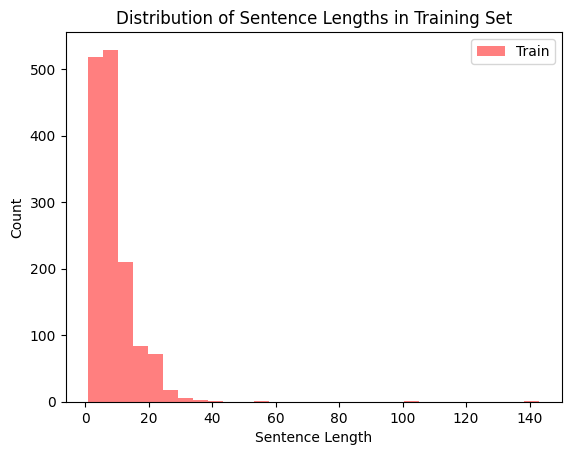

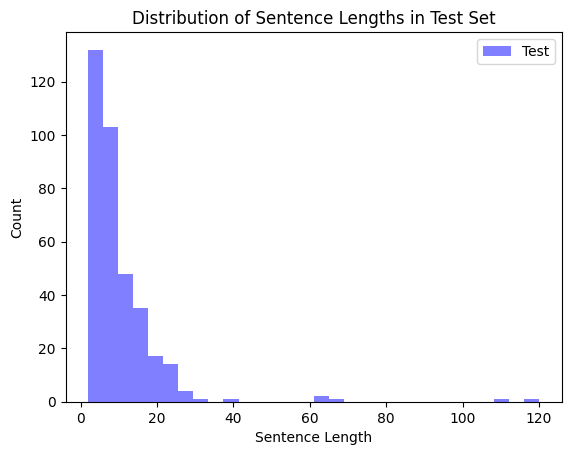


Max sentence length: 143


In [ ]:
data_train['sentence_length'] = data_train[DATA_COLUMN].apply(lambda x: len(x.split()))
data_test['sentence_length'] = data_test[DATA_COLUMN].apply(lambda x: len(x.split()))

plt.hist(data_train['sentence_length'], bins=30, alpha=0.5, color='r', label='Train')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths in Training Set')
plt.legend()
plt.show()

plt.hist(data_test['sentence_length'], bins=30, alpha=0.5, color='b', label='Test')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths in Test Set')
plt.legend()
plt.show()

max_len = max(data_train['sentence_length'].max(), data_test['sentence_length'].max())
print("\nMax sentence length:", max_len)

We can conclude that the max_len can be chosen to be ___.

#Training Requirements

Let's start by creating the dataset needed for training and testing, we will use the Dataset class from pytorch as our base class.

For tokenization, we will be using the autotokenizer from HuggingFace.

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.data.processors.utils import InputFeatures
from transformers import AutoTokenizer

#define the Dataset class
class SADataset(Dataset):
  def __init__(self, texts, labels, model_name, max_len, label_map):
    #hold the text and reviews inside the dataset class
    self.texts = texts
    self.labels = labels
    self.label_map = label_map
    self.tokenizer_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_len = max_len

  def __len__(self):
    #returns the length of the dataset
    return len(self.texts)

  def __getitem__(self, item):
    # Select the example based on the item ID
    text = str(self.texts[item])
    label = self.labels[item]

    input_dict = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding = 'max_length',
          truncation= True
      )

    return InputFeatures(input_ids=input_dict["input_ids"],
                         token_type_ids=input_dict['token_type_ids'],
                         attention_mask=input_dict["attention_mask"],
                         label=self.label_map[self.labels[item]])

**Question 4:** Define the evaluation metrics that we will need, including `accuracy_score`, `f1_score`, `precision_score` and `recall_score` from sklearn.

In [ ]:
def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  assert len(preds) == len(pred.label_ids)

  macro_f1 = f1_score(pred.label_ids, preds, average='macro')
  macro_f1_pos_neg = f1_score(pred.label_ids, preds, labels=[1], average='macro')
  macro_precision = precision_score(pred.label_ids, preds, average='macro')
  macro_recall = recall_score(pred.label_ids, preds, average='macro')
  acc = accuracy_score(pred.label_ids, preds)

  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

## Preprocess the dataset
Let's start by defining the AraBERT preprocessor:

In [ ]:
from arabert.preprocess import ArabertPreprocessor

model_name = 'aubmindlab/bert-base-arabertv02'
arabert_prep = ArabertPreprocessor(model_name)

**Question 5:** Apply preprocessing for the text column using the arabert preprocessor:

In [ ]:
data_train[DATA_COLUMN] = data_train[DATA_COLUMN].apply(lambda x: arabert_prep.preprocess(x))
data_test[DATA_COLUMN] = data_test[DATA_COLUMN].apply(lambda x: arabert_prep.preprocess(x))

Let's extract the label to id map:

In [ ]:
label_list = list(data_test[LABEL_COLUMN].unique())
label_map = { v:index for index, v in enumerate(label_list) }
print(label_map)

{'Negative': 0, 'Positive': 1}


**Question 6:** Create the train and test SADataset:

In [ ]:
# Define the max_len value
max_len = 143

# Create the train dataset
train_dataset = SADataset(
    texts=data_train['text'].to_list(),
    labels=data_train['label'].to_list(),
    model_name=model_name,
    max_len=max_len,
    label_map=label_map
)

# Create the test dataset
test_dataset = SADataset(
    texts=data_test['text'].to_list(),
    labels=data_test['label'].to_list(),
    model_name=model_name,
    max_len=max_len,
    label_map=label_map
)

# Setup the HuggingFace trainer

We will be using the `bert-base-arabertv02` from HuggingFace models by Antoun et Al (2020). We can choose other Arabic BERT models by just changing the path here from `https://huggingface.co/models`.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We can now set up the training arguments, you can more information from https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 4,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_macro_f1',
    greater_is_better = True,
    seed = 42
  )

In [ ]:
training_args.__dict__

{'output_dir': './train',
 'overwrite_output_dir': False,
 'do_train': False,
 'do_eval': True,
 'do_predict': False,
 'evaluation_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
 'prediction_loss_only': False,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 16,
 'per_gpu_train_batch_size': None,
 'per_gpu_eval_batch_size': None,
 'gradient_accumulation_steps': 2,
 'eval_accumulation_steps': None,
 'eval_delay': 0,
 'learning_rate': 5e-05,
 'weight_decay': 0.0,
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_epsilon': 1e-08,
 'max_grad_norm': 1.0,
 'num_train_epochs': 4,
 'max_steps': -1,
 'lr_scheduler_type': <SchedulerType.LINEAR: 'linear'>,
 'warmup_ratio': 0.0,
 'warmup_steps': 0,
 'log_level': 'passive',
 'log_level_replica': 'warning',
 'log_on_each_node': True,
 'logging_dir': './train/runs/Nov02_11-43-18_58e219c34d18',
 'logging_strategy': <IntervalStrategy.STEPS: 'steps'>,
 'logging_first_step': False,
 'logging_steps': 500,
 'logging_nan_inf_filter': True,
 

**Question:** Initialize the Trainer and start training:

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=model_name)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
# Start training
trainer.train()

#  Saving the best model

Before saving the model, let's change the label2id in the config file, and get the id to label map.

In [ ]:
trainer.model.config.label2id = label_map
inv_label_map = { v:k for k, v in label_map.items()}
trainer.model.config.id2label = inv_label_map

In [ ]:
#save the model in the folder
trainer.save_model("best_sa_model")
test_dataset.tokenizer.save_pretrained("best_sa_model")

('best_sa_model/tokenizer_config.json',
 'best_sa_model/special_tokens_map.json',
 'best_sa_model/vocab.txt',
 'best_sa_model/added_tokens.json',
 'best_sa_model/tokenizer.json')

# Loading the model for inference
We can use HuggingFace pipelines to load the model for inference:

In [ ]:
from transformers import pipeline
pipe = pipeline(
        "sentiment-analysis",
        model = "best_sa_model",
        device=0, # set device to 0 for CUDA
        )

In [ ]:
pipe("انا لا احبك")

[{'label': 'Positive', 'score': 0.5454723238945007}]

In [ ]:
pipe("انا احبك")

[{'label': 'Positive', 'score': 0.5379020571708679}]